In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import time
import datetime as dt
import re
import numpy as np
import pandas as pd
from stock_scraper import get_stock_prices
import matplotlib.pyplot as plt
import seaborn as sns

from Markowitz import get_vol, opt_weight

%matplotlib inline

In [4]:
from IPython.display import HTML

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [6]:
def convert_to_df(df_str):
    header = re.findall("[ , \w]+\\n", df_str)[0]
    columns = re.findall("[\w]+", header)
    number_cols = len(columns) + 1 # Including index as column
    
    n = len(columns)
    all_numbers = re.findall("[-,.,0-9]+", df_str)
    values = [float(all_numbers[i]) for i in range(len(all_numbers)) if i % number_cols != 0]
    vals_array = np.array(values).reshape((int(len(values) / n), n))
    
    tickers = re.findall('\[(.*)\]', df_str)
    
    header = re.findall("[ , \w]+\\n", df_str)[0]
    columns = re.findall("[\w]+", header)
    
    result_df = pd.DataFrame(index=tickers, data=vals_array, columns=columns)
    
    return result_df

In [13]:
driver = webdriver.Chrome("/Users/Badre/Desktop/Developer/Selenium_Webdrivers/chromedriver")

# Get to algorithm login page
driver.get("https://www.quantopian.com/signin?return_to=/algorithms")

# Log in and proceed to Algorithms page
username = driver.find_element_by_id("user_email")
password = driver.find_element_by_id("user_password")
username.send_keys("cib.pairs@gmail.com")
password.send_keys("CIBPairs17")
password.send_keys(Keys.ENTER)
time.sleep(0.5)

# Click on the strategy we want to run
strategy_link = driver.find_element_by_partial_link_text("Smart Beta Strategy (Badre) (Copy)").click()

# Edit the date and init investment fields
start_date_field = driver.find_element_by_id("daily_backtest_start_date_field")
end_date_field = driver.find_element_by_id("daily_backtest_end_date_field")
init_investment_field = driver.find_element_by_id("daily_backtest_capital_base_box")

today = dt.date.today()
start_date = today - dt.timedelta(2)
start_date_field.clear()
start_date_field.send_keys('03/13/2018')#start_date.strftime('%m/%d/%Y'))
start_date_field.send_keys(Keys.ENTER)

today_string = '03/14/2018'#today.strftime('%m/%d/%Y')
end_date_field.clear()
end_date_field.send_keys(today_string)
end_date_field.send_keys(Keys.ENTER)
time.sleep(0.05)

if end_date_field.get_attribute("value") != today_string:
    driver.close()
    raise KeyboardInterrupt("Data for today's date has not been uploaded yet. Exiting...")
    

init_investment = "5000"
init_investment_field.clear()
init_investment_field.send_keys(init_investment)
init_investment_field.send_keys(Keys.ENTER)


# Build algorithm
build_button = driver.find_element_by_id("validate-button")
build_button.click()

print("Starting algo...")
backtest_started = False
while not backtest_started:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        backtest_started = True
        continue
    

backtest_finished = False

print("Waiting on algo results...")
while not backtest_finished:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        continue
        
    print("Done")
    backtest_finished = True
        
        
# Extract weights and tickers
weights_msg = driver.find_elements_by_xpath("//*[contains(text(), 'WEIGHTS:')]")
weights_txt = weights_msg[-1].text

tickers = re.findall('\[(.*)\]', weights_txt)
weights = re.findall('[-,.,0-9]*\\n', weights_txt)
weights = [el.replace('\n', '') for el in weights]
weights = [float(weight) for weight in weights]
       
portfolio = pd.Series(index = tickers, data = weights)
print("\nAlgo picks:\n" + str(portfolio))

# Extract scores of stocks picked
scores_msg = driver.find_elements_by_xpath("//*[contains(text(), 'FACTOR SCORES:')]")
scores_txt = scores_msg[-1].text
scores_df = convert_to_df(scores_txt)

# Extract scores of bottom ranked stocks
bottom_scores_msg = driver.find_elements_by_xpath("//*[contains(text(), 'BOTTOM SCORES:')]")
bottom_scores_txt = bottom_scores_msg[-1].text
bottom_scores_df = convert_to_df(bottom_scores_txt)

# Extract scores of top ranked stocks
top_scores_msg = driver.find_elements_by_xpath("//*[contains(text(), 'TOP SCORES:')]")
top_scores_txt = top_scores_msg[-1].text
top_scores_df = convert_to_df(top_scores_txt)


print("\nPortfolio Scores:\n", scores_df)
print("\nBottom Scores:\n", bottom_scores_df)
print("\nTop Scores:\n", top_scores_df)

time.sleep(5)
driver.close()

Starting algo...
Waiting on algo results...
Done

Algo picks:
ECYT   -0.506079
RKDA   -0.292577
GS     -0.201343
GOOG    0.317365
AMP     0.329341
ARGS    0.353293
dtype: float64

Portfolio Scores:
       composite  momentum_score  sentiment_score  value_score
ECYT  -0.559777            -1.0        -0.238630    -0.321626
RKDA  -0.677430            -1.0        -0.626384    -0.134384
GS    -0.285083            -0.5        -0.070353    -0.284708
GOOG   0.206161             0.0         0.117595     0.795615
AMP    0.175037             0.0         0.521666    -0.168144
ARGS   0.953775             0.5         0.052312     3.664251

Bottom Scores:
       composite  momentum_score  sentiment_score  value_score
ECYT  -0.559777            -1.0        -0.238630    -0.321626
RKDA  -0.677430            -1.0        -0.626384    -0.134384
GS    -0.285083            -0.5        -0.070353    -0.284708
CLSD  -0.382076            -1.0         0.044809     0.000000
ZSAN  -0.269278            -0.5        -

# Analysis of Portfolio Picks

Raw Portfolio Picks


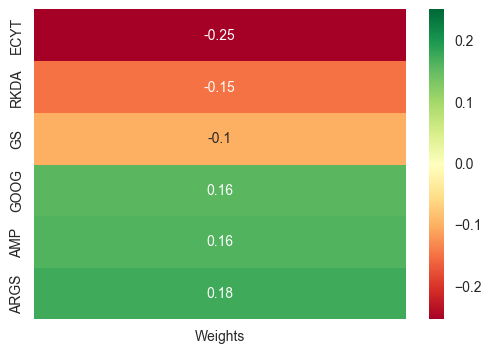

In [256]:
print("Raw Portfolio Picks")
sns.heatmap(pd.DataFrame(portfolio/2, columns=['Weights']), annot=True, cmap='RdYlGn')

Portfolio Factor Analysis


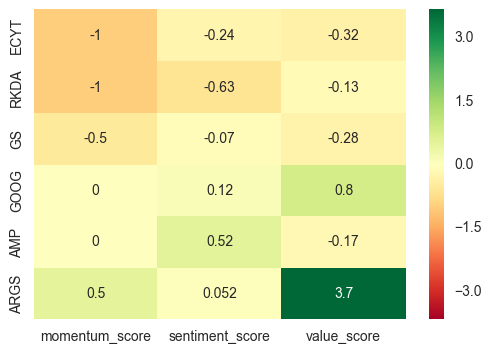

In [201]:
print("Portfolio Factor Analysis")
sns.heatmap(scores_df.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [202]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(portfolio.index, str(start), str(today))['Adj Close']

Succeeded in 6.29s after 1 attempts


In [203]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)

In [204]:
rets = prices.pct_change()
A = np.array(rets.dropna())
for i in range(A.shape[1]):
    A[:, i] -= np.mean(A[:, i])

2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAILY RETURNS


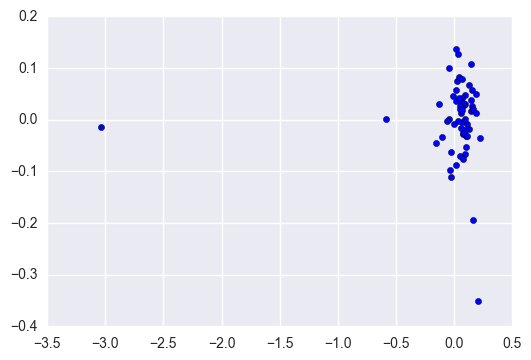

In [205]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAILY RETURNS" % COVAR_LOOKBACK)
plt.scatter(M.T[0], M.T[1])

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


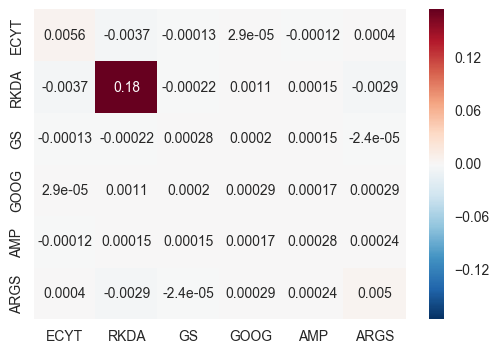

In [206]:
cov_mat = rets.cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=True, center=0)

In [207]:
return_sd = pd.DataFrame(index = portfolio.index)
return_sd['E[r]'] = scores_df['composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [208]:
def get_MVP(mu_vec, cov_mat, mark_vols, mark_rets, stocks):
    MVP_index = np.argmin(mark_vols)
    MVP = opt_weight(mark_rets[MVP_index], cov_mat, mu_vec)
    MVP_series = pd.Series(index=stocks, data=MVP.reshape((len(MVP))))
    print("Minimum Variance Portfolio:\n" + str(MVP_series.sort_values()))
    
    return MVP_series

In [209]:
def get_market_port(mu_vec, cov_mat, mark_vols, mark_rets, rf, stocks):
    derivatives = []
    for i in range(1, len(mark_rets) - 1):
        derivative = (mark_rets[i + 1] - mark_rets[i - 1]) / (mark_vols[i + 1] - mark_vols[i - 1])
        derivatives.append(derivative)
        
    cap_mkts_slopes = []
    for i in range(1, len(mark_rets) - 1):
        cap_mkts_slope = (mark_rets[i] - rf) / mark_vols[i]
        cap_mkts_slopes.append(cap_mkts_slope)
        
    MVP_index = np.argmax(derivatives)
    market_portfolio_index = np.argmin((np.array(derivatives[MVP_index:]) - np.array(cap_mkts_slopes[MVP_index:]))**2)
    market_portfolio_index += MVP_index
    market_portfolio_ret = mark_rets[market_portfolio_index - 1]
    market_portfolio = opt_weight(market_portfolio_ret, cov_mat, mu_vec)
    market_port_series = pd.Series(index=stocks, data=market_portfolio.reshape((len(market_portfolio))))
    
    cap_mkt_slope = cap_mkts_slopes[market_portfolio_index]
    
    print("Market Portfolio, assuming risk-free rate of %.2f:\n" % rf + str(market_port_series.sort_values()))
    
    return market_port_series, cap_mkt_slope
    

In [210]:
RF_RATE = 0.03

def plot_eff_front(mu_vec, cov_mat, stocks):
    mu_vec = mu_vec.reshape((len(mu_vec), 1))
    rets = np.linspace(-2 * np.abs(min(mu_vec)), 2*np.abs(max(mu_vec)), 100)
    vols = [get_vol(opt_weight(r, cov_mat, mu_vec), cov_mat) for r in rets]
    
    MVP = get_MVP(mu_vec, cov_mat, vols, rets, stocks)
    market_port, cap_mkt_slope = get_market_port(mu_vec, cov_mat, vols, rets, RF_RATE, stocks)
    x = np.linspace(0, max(vols), 100)
    cap_mkts_line = [RF_RATE + cap_mkt_slope*x for x in x]
    
    plt.plot(vols, rets)
    plt.plot(x, cap_mkts_line)
    plt.xlim(xmin=0)
    
    return MVP, market_port

In [211]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
           E[r]       vol
ECYT -0.559777  0.074907
RKDA -0.677430  0.418489
GS   -0.285083  0.016830
GOOG  0.206161  0.017014
AMP   0.175037  0.016822
ARGS  0.953775  0.070484


Minimum Variance Portfolio:
RKDA    0.001723
ARGS    0.010238
ECYT    0.052507
GOOG    0.128794
GS      0.399203
AMP     0.407535
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
GS     -3.129258
ECYT   -0.133767
ARGS   -0.036165
RKDA   -0.030276
AMP     1.184681
GOOG    3.144785
dtype: float64


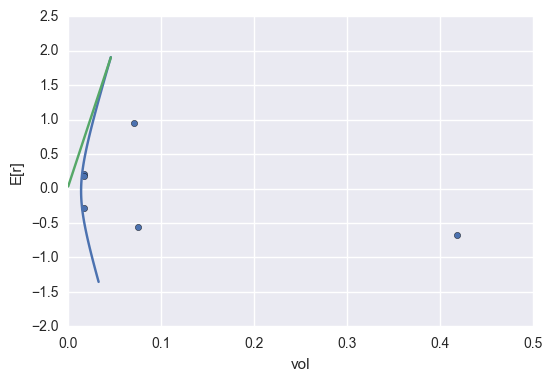

In [212]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP1, market_port1 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), portfolio.index)

In [242]:
def unlever_portfolio(portfolio):
    unlevered_port = portfolio.copy()
    short_sum = 0
    long_sum = 0
    for weight in unlevered_port:
        if weight < 0:
            short_sum -= weight
        else:
            long_sum += weight
            
    for i in range(len(unlevered_port)):
        if unlevered_port[i] < 0:
            unlevered_port[i] /= short_sum
        else:
            unlevered_port[i] /= long_sum

    if short_sum != 0:
        unlevered_port /= 2
            
    return unlevered_port

Unlevered Minimum Variance Portfolio


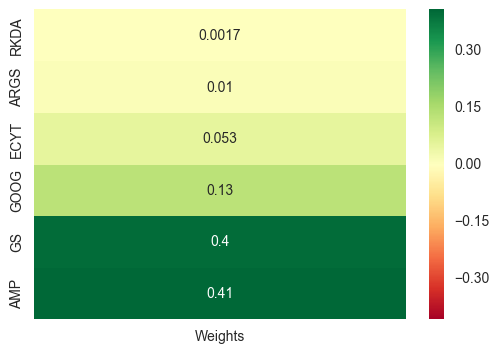

In [252]:
unlevered_MVP1 = unlever_portfolio(MVP1)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


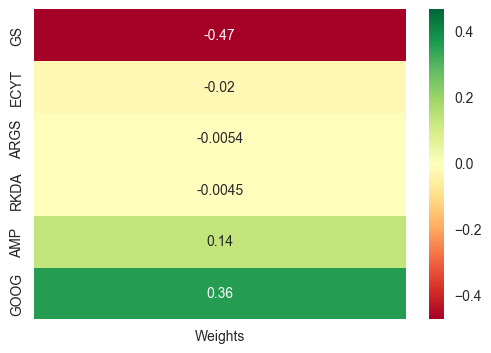

In [253]:
unlevered_market_port1 = unlever_portfolio(market_port1)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

# Analysis of Other Top and Bottom Stocks

In [218]:
all_scores = pd.concat([bottom_scores_df, top_scores_df], axis=0)

Factor Analysis


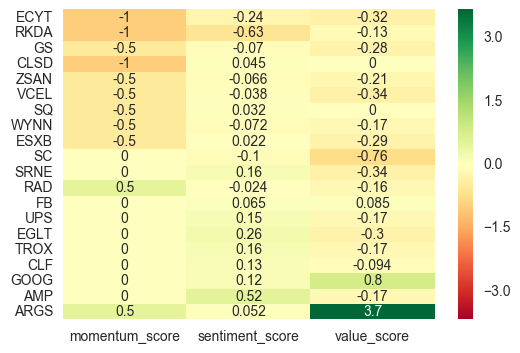

In [219]:
print("Factor Analysis")
sns.heatmap(all_scores.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [220]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(all_scores.index, str(start), str(today))['Adj Close']

Succeeded in 4.60s after 1 attempts


In [221]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)

In [222]:
rets = prices.pct_change()
A = np.array(rets.dropna())
for i in range(A.shape[1]):
    A[:, i] -= np.mean(A[:, i])

2D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAILY RETURNS


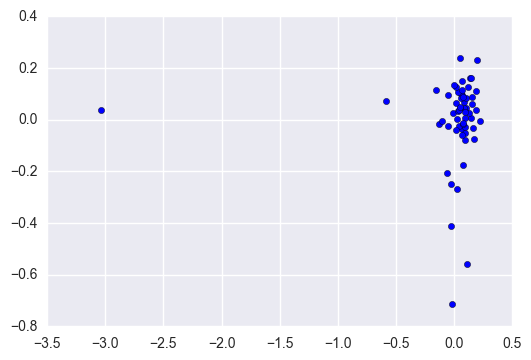

In [223]:
U, s, V = np.linalg.svd(A)
V = V.T
M = A @ V[:, :2]
print("2D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAILY RETURNS" % COVAR_LOOKBACK)
plt.scatter(M.T[0], M.T[1])

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


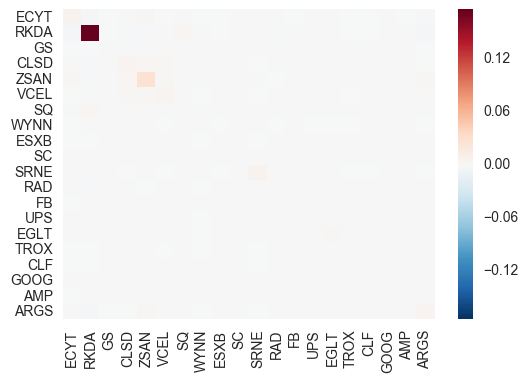

In [224]:
cov_mat = rets.cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=False, center=0)

In [225]:
return_sd = pd.DataFrame(index = all_scores.index)
return_sd['E[r]'] = all_scores['composite']
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [226]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
           E[r]       vol
ECYT -0.559777  0.074907
RKDA -0.677430  0.418489
GS   -0.285083  0.016830
CLSD -0.382076  0.070627
ZSAN -0.269278  0.163081
VCEL -0.282304  0.065634
SQ   -0.187399  0.031390
WYNN -0.262690  0.031199
ESXB -0.248906  0.017815
SC   -0.193011  0.014776
SRNE -0.002959  0.082141
RAD   0.158079  0.033550
FB    0.042710  0.018072
UPS   0.026631  0.016077
EGLT  0.042759  0.046852
TROX  0.029938  0.033724
CLF   0.033543  0.036156
GOOG  0.206161  0.017014
AMP   0.175037  0.016822
ARGS  0.953775  0.070484


Minimum Variance Portfolio:
SQ     -0.116872
GOOG   -0.115466
CLF    -0.078413
TROX   -0.038821
SRNE   -0.025634
AMP    -0.020176
ARGS   -0.018564
CLSD   -0.016821
ZSAN   -0.011560
VCEL   -0.009871
EGLT    0.000279
RKDA    0.001487
ECYT    0.018590
GS      0.066512
RAD     0.072497
WYNN    0.101445
ESXB    0.177478
SC      0.286491
FB      0.286510
UPS     0.440907
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
GS     -2.538215
SC     -0.757034
SQ     -0.589437
TROX   -0.117225
ECYT   -0.096501
ZSAN   -0.066098
VCEL   -0.051172
ESXB   -0.046363
ARGS   -0.045429
SRNE   -0.039662
RKDA   -0.014681
FB      0.046545
RAD     0.084783
CLSD    0.120327
CLF     0.168974
WYNN    0.171388
EGLT    0.202984
UPS     0.443054
AMP     1.067219
GOOG    3.056544
dtype: float64


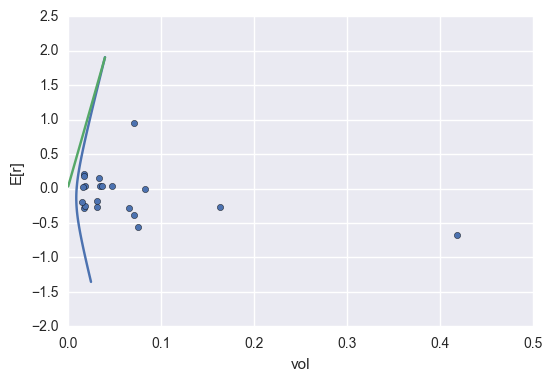

In [227]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP2, market_port2 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), all_scores.index)

Unlevered Minimum Variance Portfolio


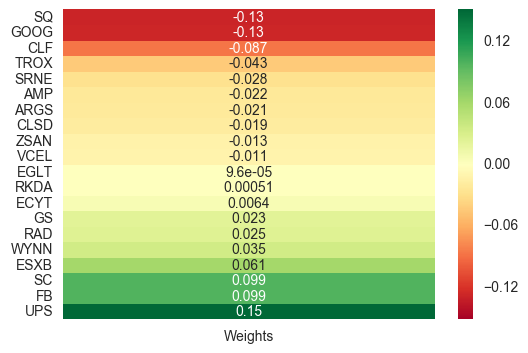

In [254]:
unlevered_MVP2 = unlever_portfolio(MVP2)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


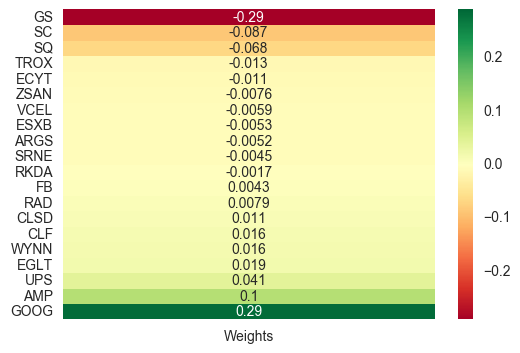

In [255]:
unlevered_market_port2 = unlever_portfolio(market_port2)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)